## MACS207b - DM2 - Hawkes process

*Giraud Hippolyte, Guerrini Valerio, Sarotte Philippe*

### Introduction

Avec l'essor de l'économie digitale, la cyber sécurité et le contrôle du risque d'attaques informatiques sont devenus une problématique essentielle pour toutes les entreprises.  
Il est donc extrêmement intéressant de disposer d'un modèle permettant de prévoir le risque de subir une attaque informatique à un moment donné. 

Après avoir écarté l'éventualité d'occurences Poissoniennes en remarquant que deux inter-arrivées successives étaient fortement corrélées, la modélisation de l'occurence de cyber attaques explorée dans l'article (1) (c.f. bibliographie à la fin) est celle par un processus d'Hawkes à excitations spontanées.

Dans la suite, nous nous proposons d'étudier une simplification de ce modèle.  
Notre point de départ est l'hypothèse suivante:

Nous supposons que l'occurence des attaques peut être modélisée par un processus de Hawkes d'intensité:
$$
\begin{align*} 
\dot{y}(N,t) &= \alpha + \beta\int_{0}^{t^-} e^{-\gamma(t-s)} \, dN(s) \\
&= \alpha + \beta\sum_{T_q<t} e^{-\gamma(t-T_q)} \
\end{align*}
$$

Commençons par interpréter les différents paramètres:

- $\alpha$ est l'intensité initiale du processus. Avant le premier saut, le processus est un processus de Poisson d'intensité $\alpha$.
- $\beta$ est la valeur de l'excitation de l'intensité au moment des sauts de N. En effet on remarque que $ \dot{y}(N,T_k) - \dot{y}(N,T_k^-) = \beta$ .
- Cette excitation est attenuée au cours du temps. Elle décroit exponentiellement et $\frac{1}{\gamma}$ est le temps caractéristique de cette décroissance. Ainsi, après un temps assez long depuis la dernière excitation, le processus revient à son état initial.

Dans toute la suite, nous utiliserons la base de données Privacy Rights Clearinghouse (PRC) et nous regarderons uniquement les failles correspondants à des hacks.
Commençons par visualiser le nombre d'occurences $N(t)$ d'attaques informatiques au cours du temps :

In [502]:
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize,root_scalar
from scipy.integrate import quad
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import kstest, expon

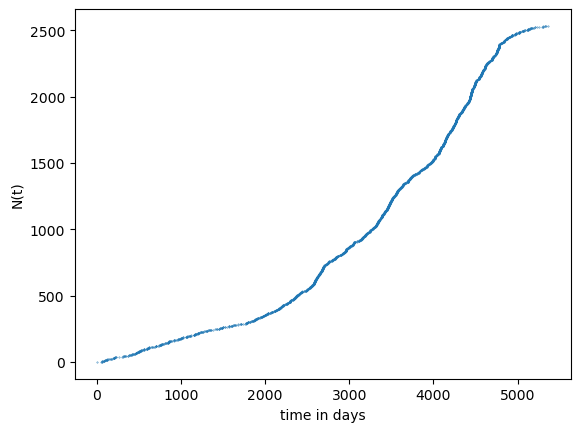

In [428]:
df=pd.read_csv("PRC.csv",sep=';')
dff=df.loc[df['Type of breach']=="HACK",'Date Made Public']
dff=dff.apply(lambda x:datetime.strptime(x,'%m/%d/%Y'))
debut=min(dff)
dff=dff-debut
dff=dff.apply(lambda x:x.days).sort_values()
l=np.asarray(dff)[1:]
plt.scatter(l,1+np.arange(len(l)),s=0.1)
plt.xlabel("time in days") 
plt.ylabel("N(t)")
plt.show()

On voit que la fréquence d'arrivées varie bien au cours du temps, ce qui écarte totalement l'hypothèse Poissonienne et nous conforte dans le choix de notre modèle.

### Détermination des paramètres $\alpha$, $\beta$ et $\gamma$.

On veut déterminer les paramètres $\alpha$, $\beta$ et $\gamma$ pour lesquels le modèle est le plus précis, pour cela on peut chercher les paramètres maximisant la vraisemblance.  
On a montré en exercice que la log-vraisemblance est donnée par la formule suivante: 

$$ \log L(N,t)=\sum\limits_{T_n \leq t} \log (\alpha + \beta\sum\limits_{j=1}^{n-1} e^{-\gamma(T_n-T_j)}) +(1- \alpha)t-\frac{\beta}{\gamma}\sum\limits_{T_n \leq t} (1-e^{-\gamma(t-T_n)})$$.

In [429]:
#On définit l'opposé de la Log-Likeliwood, qu'on minimisera ensuite

def vectorized_logL(T, t, alpha, beta, gamma):
    mask = T <= t
    T_masked = T[mask]
    n = len(T_masked)
    
    #on commence par calculer la somme d'exponentielles 
    
    times_differences=np.tril(-gamma*(T.reshape(-1,1)-T_masked[:-1]), k=-1)
    
    #on obtient les differences de temps, nultipliées par -gamma
    #à la position (i>j) on a -gamma*(Ti-Tj)
    
    exps=np.exp(times_differences)
    
    #on obtient les exponentielle des -gamma(Ti-Tj)
    #il faut maintenant enlever les exp(0) qui sont au-dessus de la diagonale et sommer par ligne
    
    exp_sum = np.tril(exps,k=-1).sum(axis=1)
    
    term1 = np.log(alpha + beta * exp_sum)
    
    term2 = (beta / gamma) * (1 - np.exp(-gamma * (t - T_masked)))
    
    term3 = (1 - alpha) * t
    
    res = (term1.sum() - term2.sum() + term3)
    return res

def first_test(params):
    return -vectorized_logL(l,l[-1],params[0],params[1],params[2])

On essaye de minimiser notre fonction une première fois en utilisant les contraintes de positivité sur les variables et l'hypothèse $\frac{\beta}{\gamma}<1$.

In [430]:
#Contraintes de positivité des paramètres

def alpha_positivity(params):
    return params[0]   
def beta_positivity(params):
    return  params[1]  
def gamma_positivity(params):
    return  params[2]

#contrainte sur gamma et beta

def constraint_gamma_beta(params):
    return 1-params[1]/params[2]
    

constraints = [{'type': 'ineq', 'fun': alpha_positivity},
        {'type': 'ineq', 'fun': beta_positivity},
        {'type': 'ineq', 'fun': gamma_positivity},
        {'type': 'ineq', 'fun': constraint_gamma_beta}]

In [431]:
x_0=[0.5,0.5,0.5]

result = minimize(first_test, x_0, constraints=constraints, options={'maxiter': 1000})
optimized_params = result.x
print("alpha= " + str(optimized_params[0]) +", beta= " + str(optimized_params[1]) +", gamma= " + str(optimized_params[2]))

/var/folders/dc/2vgy793x7t15h4j_f_cy_88h0000gr/T/ipykernel_15654/1288046855.py:22: RuntimeWarning: invalid value encountered in log
  term1 = np.log(alpha + beta * exp_sum)


alpha= 0.29436787293934386, beta= 11626135.10134315, gamma= 22805964.72668297


On s'aperçoit que $\beta$ et $\gamma$ ont une valeur très élevée, ce qui signifierait que les excitations sont très fortes mais durent très peu. On a essayé de trouver la raison qui entraine à des coefficients aussi élevés et nous nous sommes rendus compte qu'avec le traitement de données utilisé on se retrouve avec des temps d'arrivées simultanés, ce qui n'est pas possible pour un processus ponctuel et qui explique nos résultats:

In [432]:
#on définit la liste des temps d'arrivés uniques et le nombre d'arrivées pour chaque temps

l_uniques=[]
count_l=[]
for t in l:
    if t not in l_uniques:
        l_uniques.append(t)
        count_l.append(1)
    else:
        i=l_uniques.index(t)
        count_l[i]+=1


#on remarque qu'il y a des doublons
len(l_uniques)==len(l)

l_uniques_array = np.array(l_uniques)

Enlever les doublons n'est pas une solution viable, puisqu'on perdrait l'effet de l'excitation et on se retrouverait avec un $\beta$ proche de 0:

In [433]:
def test_uniques(params):
    return -vectorized_logL(l_uniques_array,l_uniques[-1],params[0],params[1],params[2])

In [434]:
x_0=[0.5,0.5,0.5]

result = minimize(test_uniques, x_0, constraints=constraints, options={'maxiter': 1000})
optimized_params = result.x
print("alpha= " + str(optimized_params[0]) +", beta= " + str(optimized_params[1]) +", gamma= " + str(optimized_params[2]))

/var/folders/dc/2vgy793x7t15h4j_f_cy_88h0000gr/T/ipykernel_15654/1288046855.py:22: RuntimeWarning: invalid value encountered in log
  term1 = np.log(alpha + beta * exp_sum)


alpha= 0.2943698651195855, beta= 4.685122628199528e-08, gamma= 3.5434644513321647


Comme on s'y attendait, en enlevant les doublons on diminue énormément l'effet des excitations. On se retrouve donc avec un $\beta$ quasiment nul. Pour compenser ce problème on va faire l'hypothèse que lorsqu'il y a plusieurs attaques dans le même jour, elles sont réparties uniformément dans la journée.

In [435]:
l_adapted=np.array([])
for i in range(len(l_uniques)):
    lin=np.linspace(0,1,num=count_l[i],endpoint=False)
    ts=l_uniques[i]+lin
    l_adapted=np.concatenate((l_adapted,ts))

In [436]:
def test_adapted(params):
    return -vectorized_logL(l_adapted,l_uniques[-1],params[0],params[1],params[2])

In [478]:
x_0=[0.5,0.5,0.5]

result = minimize(test_adapted, x_0, constraints=constraints, options={'maxiter': 1000})
optimized_params = result.x
alpha,beta,gamma=optimized_params[0],optimized_params[1],optimized_params[2]
print("alpha= " + str(alpha) +", beta= " + str(beta) +", gamma= " + str(gamma))

/var/folders/dc/2vgy793x7t15h4j_f_cy_88h0000gr/T/ipykernel_15654/1288046855.py:22: RuntimeWarning: invalid value encountered in log
  term1 = np.log(alpha + beta * exp_sum)
/var/folders/dc/2vgy793x7t15h4j_f_cy_88h0000gr/T/ipykernel_15654/1288046855.py:15: RuntimeWarning: overflow encountered in exp
  exps=np.exp(times_differences)
/var/folders/dc/2vgy793x7t15h4j_f_cy_88h0000gr/T/ipykernel_15654/1288046855.py:24: RuntimeWarning: overflow encountered in exp
  term2 = (beta / gamma) * (1 - np.exp(-gamma * (t - T_masked)))
/var/folders/dc/2vgy793x7t15h4j_f_cy_88h0000gr/T/ipykernel_15654/1288046855.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  term2 = (beta / gamma) * (1 - np.exp(-gamma * (t - T_masked)))
/var/folders/dc/2vgy793x7t15h4j_f_cy_88h0000gr/T/ipykernel_15654/1288046855.py:24: RuntimeWarning: invalid value encountered in multiply
  term2 = (beta / gamma) * (1 - np.exp(-gamma * (t - T_masked)))
/var/folders/dc/2vgy793x7t15h4j_f_cy_88h0000gr/T/ipykernel_15654

alpha= 0.042822269436279224, beta= 0.04307448356708084, gamma= 0.0473386977656446


On obtient donc des excitations d'intensité assez faibles, mais avec un temps caractéristique $\frac{1}{\gamma} \approx 20$ jours.

### Vérification de l'estimation de nos paramètres

Commençons par visualiser l'évolution de $\dot{y}$ au cours du temps:

In [480]:
def y_point(T,t,alpha,beta,gamma):
    mask = T < t
    T_masked= T[mask]
    term1=beta*np.exp(-gamma*(t-T_masked)).sum()
    
    return alpha + term1

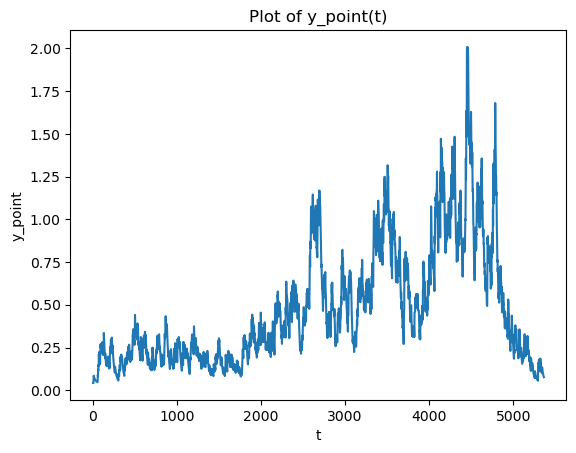

In [481]:
t_values = np.linspace(0, l[-1], len(l))

y_values = [y_point(l,t,alpha,beta,gamma) for t in t_values]

plt.plot(t_values, y_values)
plt.xlabel('t')
plt.ylabel('y_point')
plt.title('Plot of y_point(t)')
plt.show()

On voit que lorsqu'il y a une excitation, l'intensité augmente fortement et peut atteindre des pics très élevés.  
Afin de tester notre modèle on peut utiliser le fait que si notre estimation est correcte, les $(y(N,T_q(N),1\leq q)$ correspondent aux temps d'arrivés d'un processus de Poisson d'intensité $1$.  
Pour commencer on peut donner la formule analytique des $y(N,T_q)$ obtenue en intégrant $\dot{y}$:

$$\begin{align*}
y(N,T_q) &= \int_{0}^{T_q} \dot{y}(t) dt \\
&= \int_{0}^{T_q} \alpha + \beta\sum_{T_k<t} e^{-\gamma(t-T_k)} dt \\
&= \alpha T_q + \int_{0}^{T_q} \beta\sum_{T_k} e^{-\gamma(t-T_k)} \mathbb{1}(T_k<t) dt \\
(\text{puisque } T_k < t < T_q)&= \alpha T_q + \int_{0}^{T_q} \beta\sum_{k<q} e^{-\gamma(t-T_k)} \mathbb{1}(T_k<t) dt \\
&= \alpha T_q + \beta\sum_{k<q} \int_{0}^{T_q} e^{-\gamma(t-T_k)} \mathbb{1}(T_k<t) dt \\
&= \alpha T_q + \beta\sum_{k<q} \int_{T_k}^{T_q} e^{-\gamma(t-T_k)} dt \\
&= \alpha T_q + \frac{\beta}{\gamma}\sum_{k<q} (1-e^{-\gamma(T_q-T_k)})
\end{align*}$$


In [491]:
def y_T(T,q,alpha,beta,gamma):
    mask = T < T[q]
    T_masked=T[mask]
    exps=1-np.exp(-gamma*(T[q]-T_masked))
    term1= ( beta / gamma )*exps.sum()
    term2 = alpha*T[q]
    return term1+term2

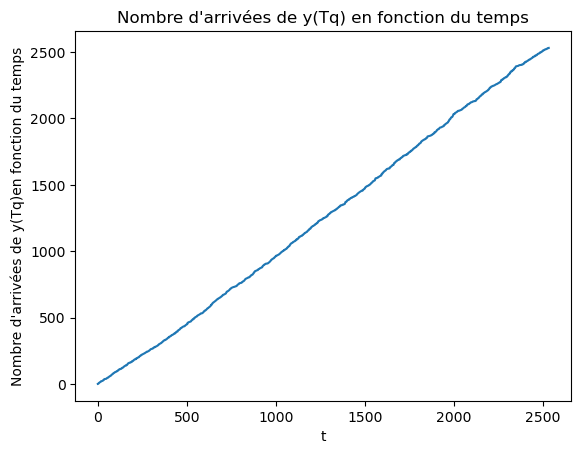

In [493]:
t_values = [y_T(l_adapted,q,alpha,beta,gamma) for q in range(len(l_adapted))]
integers=np.arange(0,len(t_values))


plt.plot(t_values, integers)
plt.xlabel('t')
plt.ylabel("Nombre d'arrivées de y(Tq)en fonction du temps")
plt.title("Nombre d'arrivées de y(Tq) en fonction du temps")
plt.show()

On voit que l'on obtient quasiment une droite, ce qui nous fait penser que les $(y(N,T_q(N),1\leq q)$ suivent bien une loi de Poisson de paramètre $1$.

Nous pouvons faire une autre vérification heuristique à partir de l'histogramme des inter-arrivées que l'on compare à la densité d'une distribution exponentielle de paramètre 1:

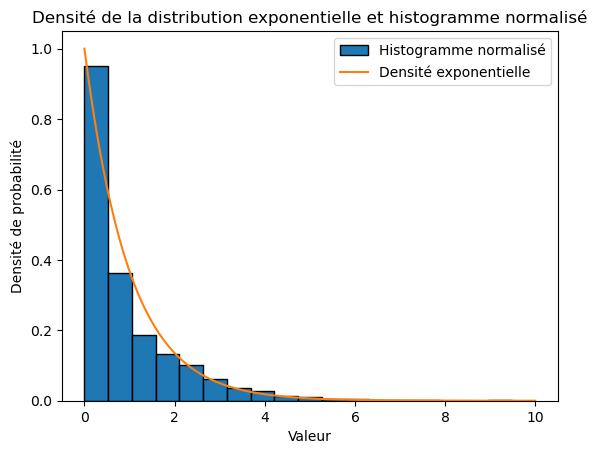

In [500]:
# Paramètre de la distribution exponentielle
lambda_param = 1

time_arrivals=np.array(t_values)

inter_arrivals= time_arrivals[1:]-time_arrivals[:-1]

# Plage de valeurs
x = np.linspace(0, 10 , 1000 )

bins = np.linspace(0, 10 , 20)

# Calcul de la densité de probabilité exponentielle
pdf = lambda_param * np.exp(-lambda_param * x)

# Tracer l'histogramme normalisé
plt.hist(inter_arrivals, bins=bins, edgecolor='black', density=True, label='Histogramme normalisé')

# Tracer la densité de probabilité exponentielle
plt.plot(x, pdf, label='Densité exponentielle')

plt.xlabel('Valeur')
plt.ylabel('Densité de probabilité')
plt.title('Densité de la distribution exponentielle et histogramme normalisé')
plt.legend()
plt.show()

On voit que cette vérification heuristique est également très concluante, maintenant passons au test formel qui permettra d'être certains de la qualité de nos paramètres.  
On décide d'utiliser un test de Kolmogorov-Smirnov, particuliérement efficace pour comparer nos échantillons à la distribution théorique.

In [504]:
ks_statistic, p_value = kstest(inter_arrivals, 'expon', args=(0, 1))
ks_statistic,p_value    

(0.0984072818937819, 8.689621717963799e-22)

On voit qu'on a une pvalue extrêmement faible, on en déduit que le test est validé et que les paramètres utilisés pour décrire notre modèle sont très bons.